# Performance of Peer-to-Peer Loans on Prosper.com

## Investigation Overview

This investigation analyzes loans made on Prosper Marketplace, a peer-to-peer lending platform, from various perspectives. This presentation focuses on loan performance and which variables are correlated with loan outcomes.

## Dataset Overview

The dataset analyzed consists of data about 113,066 loans made on the Prosper Marketplace between 11/15/2005 and 03/12/2014. The dataset contains up to 81 variables for each loan including the characteristics of the loan itself (e.g., loan amount, interest rate, fees, number of investors and status of the loan at the time that the data was collected) and about the borrower (e.g., various credit scores and ratings, employment info, income, debt-to-income ratio, borrower's state and credit history info like date of first credit line and deliquencies). The original acquired data was in the form of a .csv file and it contained 113937 rows; however, there were 871 duplicate loans which were cleaned. There were also 133 FICO credit scores that were outside of the valid range which also required cleaning.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import datetime
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the cleaned dataset into a pandas dataframe
loans_clean = pd.read_csv('prosperLoansClean.csv')
# Convert the ListingCreationDate, ClosedDate, DateCreditPulled, LoanOriginationDate columns to datetime format
loans_clean.loc[:,'ListingCreationDate'] = pd.to_datetime(loans_clean['ListingCreationDate'])
loans_clean.loc[:,'ClosedDate'] = pd.to_datetime(loans_clean['ClosedDate'])
loans_clean.loc[:,'DateCreditPulled'] = pd.to_datetime(loans_clean['DateCreditPulled'])
loans_clean.loc[:,'LoanOriginationDate'] = pd.to_datetime(loans_clean['LoanOriginationDate'])

In [3]:
# Separate the closed and still open loans by filtering on the ClosedDate column
loans_closed = loans_clean.dropna(subset=['ClosedDate'])
loans_open = loans_clean[loans_clean['ClosedDate'].isnull()]

## Distribution of Loan Statuses

Loans that were closed by the time that the data was collected have a loan status of Completed, Chargedoff, Defaulted or Canceled. Completed means that the loan principal, interest and required fees was successfully paid. Chargedoff means that the loan payments were more than 120 days late and that collections actions have completed. This is the final state of a "defaulted" loan. A loan status of Defaulted means that the loan payments were more than 120 days late so it was closed but collections actions were still ongoing at the time that the data was collected. Finally, a status of Cancelled means that the loan was approved and funded but the borrower cancelled the transaction before the funds were transferred. 

Loans that were still open at the time that the data was collected have a different set of statuses: Current, LastPaymentInProgress and 6 status in the form of "Past Due (x-y days)" where "x-y' are "1-15", "16-30", "31-60", "61-90" or ">120". These latter 6 status are, as the text imply, indicate that loan payments are late by the specified number of days.

The following two plots show the distribution of loan statuses for closed and open loans, respectively.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

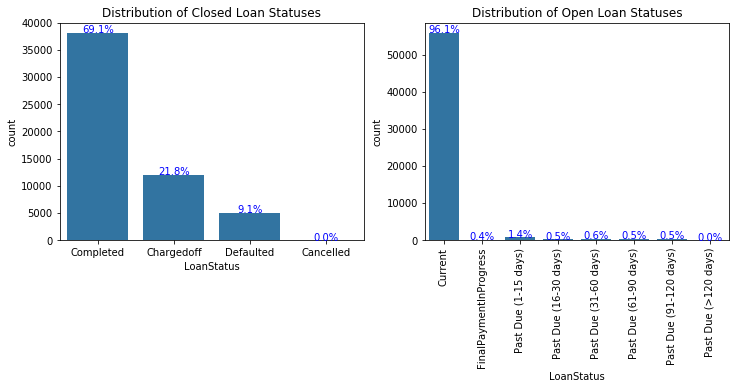

In [4]:
# Plot the distribution of the LoanStatus categorical variable in two subplots - one for closed and the other for open
fig, axes = plt.subplots(1,2,squeeze=False,figsize = (12,4))
base_color=sb.color_palette()[0]
type_order1=loans_closed['LoanStatus'].value_counts().index
sb.countplot(data=loans_closed, x='LoanStatus', color=base_color, order=type_order1, ax=axes[0,0])
type_order2=['Current','FinalPaymentInProgress','Past Due (1-15 days)','Past Due (16-30 days)','Past Due (31-60 days)','Past Due (61-90 days)','Past Due (91-120 days)','Past Due (>120 days)']
sb.countplot(data=loans_open, x='LoanStatus', color=base_color, order=type_order2, ax=axes[0,1])
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels for left subplot
plt.sca(axes[0,0])
# Label bars with proportions
n_points = loans_closed.shape[0]
cat_counts = loans_closed['LoanStatus'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just above the top of the bar
    plt.text(loc, count+10, pct_string, ha = 'center', color = 'b')

axes[0,0].set_title('Distribution of Closed Loan Statuses')

# loop through each pair of locations and labels for left subplot
plt.sca(axes[0,1])
# Label bars with proportions
n_points = loans_open.shape[0]
cat_counts = loans_open['LoanStatus'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just above the top of the bar
    plt.text(loc, count+20, pct_string, ha = 'center', color = 'b')
    
axes[0,1].set_title('Distribution of Open Loan Statuses')
plt.xticks(rotation='90')

## Explaining Disparity Between Closed and Open Loan Performance

The distribution of closed loan statuses shows that 30.9% were closed as Chargedoff or Defaulted state leaving only 69.1% of the closed loans having been completely repaid. However 96.1% of the loans that were still open were in the Current state meaning that there were no outstanding payments! It turns out that this disparity in loan performance is due to the evolution of the Prosper Marketplace over the 8+ years covered by the dataset. In the early years loans on the platform performed very poorly. In November of 2008 Prosper Marketplace shutdown because the SEC (Securities and Exchange Commission) issued a "cease and desist order" because it ruled that the loans were in fact securities and needed to be regulated. In July of 2009 prosper.com was relaunched after getting registered with the SEC and making a number of significant policy changes.

These events can be seen in the following line plot. First there is the monthly loan originations. Note that the originations counts fall to zero in late 2008 corresponding to the shutdown mentioned above. Another significant observation from this plot is the large increase in the loan origination rate towards the end of the time spanned by the dataset. This drives up the number of open loans and the number of fresh loans which have not had as much time to "go bad".

In [5]:
# Create a timeseries dataframe indexed by LoanOriginationDate and containing the columns that timeseries might be interesting
ts_loans = loans_clean[loans_clean.LoanOriginationDate < '2014-02-28'][['LoanOriginationDate', 'LoanStatus', 'BorrowerRate','ClosedDate','Investors','TroubledLoan','LoanOriginalAmount']].copy()
ts_loans.set_index('LoanOriginationDate', inplace=True)

# Groupby month
monthly_loans = ts_loans.groupby(pd.Grouper(freq="M"))

Text(0.5, 1.0, 'Monthly Loan Originations')

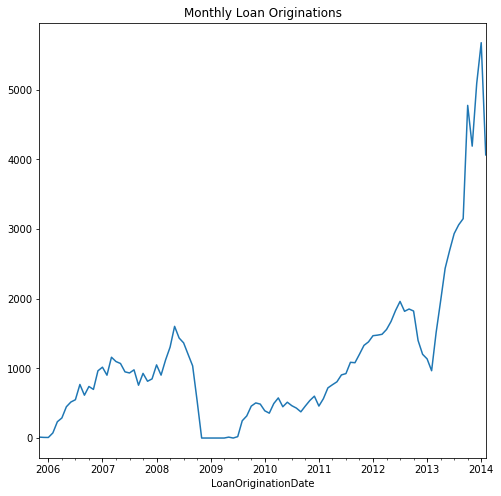

In [6]:
# Plot number of loan originations per month over the timespan of the dataset
monthly_loans['LoanStatus'].count().plot(kind='line', figsize=(8, 8))
plt.title('Monthly Loan Originations')

## Pre and Post Relaunch Loan Performance

Plotting the proportions of loans that are "troubled" (i.e., LoanStatus of Chargedoff or Defaulted for closed loans or LoanStatus of more than 30 days Past Due for open loans) for loans originated each month clearly shows the improvment after the relaunch in 2009. Again the discontinuity from late-2008 thru mid-2009 is due to the prosper.com shutdown when no loans were originated. And troubled loan rates will naturally tend to zero for origination dates approaching the end of the observation window as these loans have less time to show trouble.

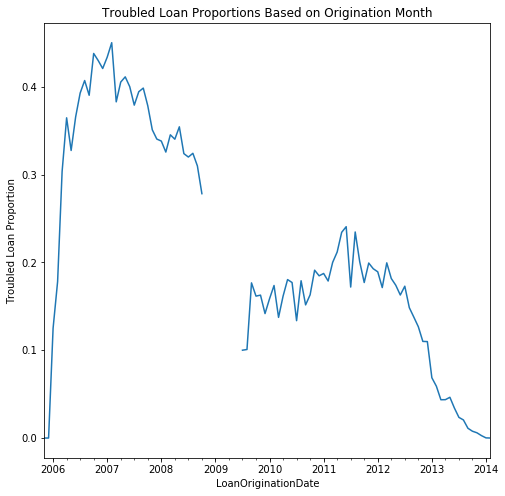

In [7]:
# Calculate and plot troubled loan rate by month of origination
monthly_loans['TroubledLoan'].agg(np.mean).plot(kind='line', figsize=(8, 8))
plt.title('Troubled Loan Proportions Based on Origination Month')
plt.ylabel('Troubled Loan Proportion');

## Improved Minimum Credit Quality Standard

One particularly significant policy change implemented on the Prosper Marketplace after the 2009 relaunch was a significant tightening of the minimum credit quality require for a borrower to get a loan. This can be clearly seen in the following plot of the distribution of the CreditScoreRangeLower variable for loans originated before and after the relaunch.

28953 84113


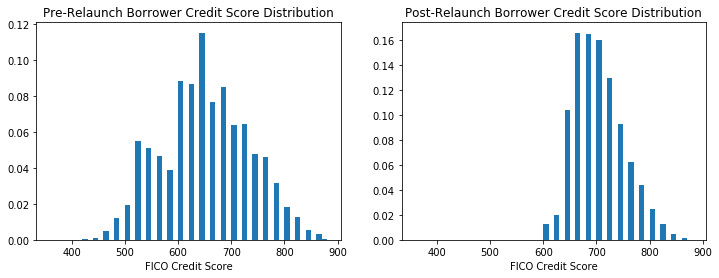

In [8]:
# Plot CreditScoreRangeLower distribution for loans originated pre- and post-relaunch
bins = np.arange(loans_clean.CreditScoreRangeLower.min(),loans_clean.CreditScoreRangeLower.max()+1,10)
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))

pre = loans_clean[loans_clean.PostRelaunch == False].CreditScoreRangeLower
post = loans_clean[loans_clean.PostRelaunch == True].CreditScoreRangeLower
pre_weights=np.ones(len(pre)) / len(pre)
post_weights=np.ones(len(post)) / len(post)

print(len(pre_weights), len(post_weights))
ax[0,0].hist(x=pre, bins=bins, weights=pre_weights)
ax[0,0].set_title('Pre-Relaunch Borrower Credit Score Distribution')
ax[0,0].set_xlabel('FICO Credit Score')
ax[0,1].hist(x=post, bins=bins, weights=post_weights)
ax[0,1].set_title('Post-Relaunch Borrower Credit Score Distribution')
ax[0,1].set_xlabel('FICO Credit Score');

## Four Borrower Creditworthiness Variables

The dataset contains four variables directly related to the creditworthiness of the borrowers: 
* FICO credit score (appears as a range, CreditScoreRangeLower and CreditScoreRangeUpper, which always spans 20 points each)
* CreditGrade with values (in order of decreasing quality) AA, A, B, C, D, E, HR (higher risk) and NC (not calculated); only applies to pre-relaunch loans
* ProsperRating with the same values as CreditGrade minus the NC value; only applies to post-relaunch loans
* ProsperScore with values of 1 to 11 with higher values for lower risk loans; only applies to post-relaunch loans

In spite of the similarity in the categories between CreditGrade and ProsperRating, these two creditworthiness variables appear to be calculated using quite distinct algorithms. Based on the data CreditGrade is computed directly from FICO credit score and so is perfectly correlated with credit score. The correlation between ProsperRating and FICO credit score is not nearly as strong as is seen in the following box plots.

Text(0.5, 1.0, 'FICO Credit Score Statistics per ProsperRating Category')

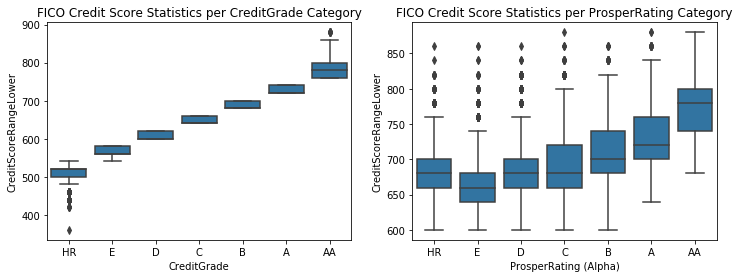

In [9]:
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))

# Plot CreditScoreRangeLower vs CreditGrade in subplot 1
base_color=sb.color_palette()[0]
cat_order=['HR','E','D','C','B','A','AA']
plt.sca(ax[0,0])
sb.boxplot(data=loans_clean, x='CreditGrade', y='CreditScoreRangeLower', color=base_color, order=cat_order)
plt.title('FICO Credit Score Statistics per CreditGrade Category')

# Boxplot CreditScoreRangeLower vs ProsperRating (Alpha)
plt.sca(ax[0,1])
sb.boxplot(data=loans_clean, x='ProsperRating (Alpha)', y='CreditScoreRangeLower', color=base_color, order=cat_order)
plt.title('FICO Credit Score Statistics per ProsperRating Category')

The fourth creditworthiness variable, ProsperScore, does not seem to be strongly correlated to either FICO credit score or ProsperRating. It was apparently introduced to predict the risk of loans going bad within the first year. The following two plots depict how ProsperScore relates to FICO credit score and ProsperRating.

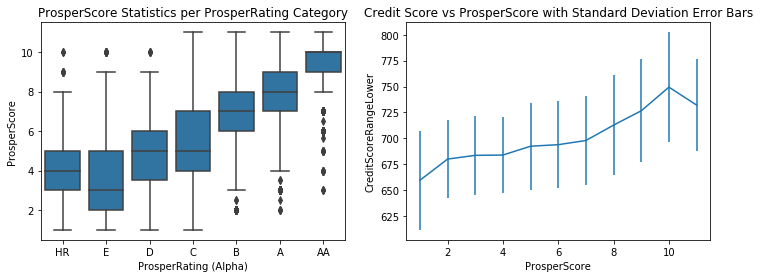

In [10]:
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))

# Plot CreditScoreRangeLower vs CreditGrade in subplot 1
base_color=sb.color_palette()[0]
cat_order=['HR','E','D','C','B','A','AA']
plt.sca(ax[0,0])
sb.boxplot(data=loans_clean, x='ProsperRating (Alpha)', y='ProsperScore', color=base_color, order=cat_order)
plt.title('ProsperScore Statistics per ProsperRating Category')

plt.sca(ax[0,1])
# Plot CreditScoreRangeLower vs ProsperScore
loans_post = loans_clean[loans_clean.PostRelaunch==True]

# set bin edges, compute centers
xbin_size = 1
xbin_edges = np.arange(0.5, loans_post.ProsperScore.max()+xbin_size, xbin_size)
xbin_centers = (xbin_edges + xbin_size/2)[:-1]

# compute statistics in each bin
data_xbins = pd.cut(loans_post['ProsperScore'], xbin_edges, right = False, include_lowest = True)
y_means = loans_post['CreditScoreRangeLower'].groupby(data_xbins).mean()
y_stds = loans_post['CreditScoreRangeLower'].groupby(data_xbins).std()

# plot the summarized data
plt.errorbar(x = xbin_centers, y = y_means.values, yerr = y_stds.values)
plt.xlabel('ProsperScore')
plt.ylabel('CreditScoreRangeLower')
plt.title('Credit Score vs ProsperScore with Standard Deviation Error Bars');

## Creditworthiness Variables' Relationships to Loan Outcomes

Given that the three creditworthiness variables (ignoring CreditGrade since it is perfectly correlated to FICO credit score) attempt to quantify a similar aspect of the borrower but yield such different statistical results leads one to ask how do they correlate to loan outcomes? The following plots attempt to answer this question. Here we use proportion of troubled loans as a metric of loan outcome.

In [11]:
# Compute TroubledLoan proportion for each ProsperRating 
gb_prosper_rating = loans_clean.groupby(by='ProsperRating (Alpha)')['TroubledLoan'].value_counts()
df_gb = gb_prosper_rating.to_frame()
df_troubled_props = df_gb.unstack(level=1, fill_value=0)
df_troubled_props.columns = ['v_false', 'v_true']
df_troubled_props['trouble_rates'] = df_troubled_props.apply(lambda row: row.v_true/(row.v_true+row.v_false), axis = 1)

# Compute TroubledLoan proportion for each ProsperScore bin 

# set bin edges, compute centers
xbin_size = 1
xbin_edges = np.arange(0.5, loans_post.ProsperScore.max()+xbin_size, xbin_size)
xbin_centers = (xbin_edges + xbin_size/2)[:-1]

# compute statistics in each bin
data_xbins = pd.cut(loans_post['ProsperScore'], xbin_edges, right = False, include_lowest = True)

trouble_prosper_score = loans_post.groupby(data_xbins)['TroubledLoan'].value_counts().to_frame().unstack(level=1, fill_value=0)
trouble_prosper_score.columns = ['v_false', 'v_true']
trouble_prosper_score['trouble_rates'] = trouble_prosper_score.apply(lambda row: row.v_true/(row.v_true+row.v_false), axis = 1)

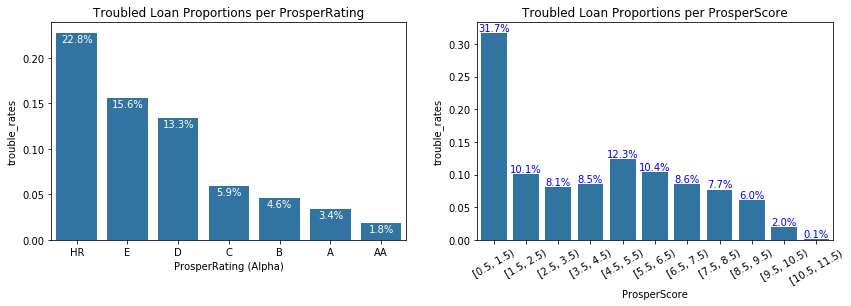

In [36]:
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (14,4))
plt.sca(ax[0,0])

# Plot TroubledLoan proportions as barchart
base_color=sb.color_palette()[0]
cat_order=['HR','E','D','C','B','A','AA']
sb.barplot(data=df_troubled_props, x=df_troubled_props.index, y='trouble_rates', color=base_color, order=cat_order)
plt.title('Troubled Loan Proportions per ProsperRating')

# Annotate bars with proportions
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
i = 0
for loc, label in zip(locs, labels):
    tr = float(df_troubled_props.loc[cat_order[i], 'trouble_rates'])
    i += 1
    pct_string = '{:0.1f}%'.format(100*tr)
    
    # print the annotation just above the top of the bar
    plt.text(loc, tr-0.01, pct_string, ha = 'center', color = 'w')
    
# bar plot ProsperScore against troubled loan proportions
plt.sca(ax[0,1])

sb.barplot(data=trouble_prosper_score, x=trouble_prosper_score.index, y='trouble_rates', color=base_color)
plt.title('Troubled Loan Proportions per ProsperScore')
plt.xticks(rotation='30')

# Annotate bars with proportions
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
i = 0
for loc, label in zip(locs, labels):
    tr = float(trouble_prosper_score.iloc[i, 2])
    i += 1
    pct_string = '{:0.1f}%'.format(100*tr)
    
    # print the annotation just above the top of the bar
    plt.text(loc, tr+0.003, pct_string, ha = 'center', color = 'b')


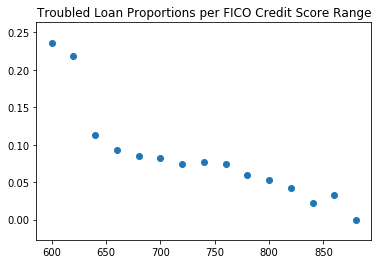

In [13]:
# Compute TroubledLoan proportion for each CreditScoreRangeLower 
trouble_credit_score = loans_clean[loans_clean.PostRelaunch==True].groupby(by='CreditScoreRangeLower')['TroubledLoan'].value_counts().to_frame().unstack(level=1, fill_value=0)
trouble_credit_score.columns = ['v_false', 'v_true']
trouble_credit_score['trouble_rates'] = trouble_credit_score.apply(lambda row: row.v_true/(row.v_true+row.v_false), axis = 1)

# Scatter plot credit score against troubled loan proportions
plt.scatter(data=trouble_credit_score, x=trouble_credit_score.index, y='trouble_rates')
plt.title('Troubled Loan Proportions per FICO Credit Score Range');

## Loan Performance

From the investor's perspective whether a loan is "troubled" or not, while clearly important, is too course a metric to quantify the performance of the investment. In addition to whether or not the loan ultimately got repaid investment performance also depends on other factors such as interest rate and fees charged for investing on the platform. Even the performance of loans that go into default and ultimately have to be charged off varies depending on how many payments are received before the borrower defaults and what, if any, funds are recovered during the post-default, collections process. 

A new feature was added to the dataset to quantify loan performance from the investor's perspective. InvestorReturnRatio is defined as the total amount paid by the borrower plus any recovery amount (only applies to defaulted loans) minus fees divided by the original amount of the loan. So if the borrower repaids the loan, the InvestorReturnRatio would be one plus the effective interest rate compounded over the term of the loan, where effective interest rate is the borrower's interest rate adjusted for fees the investor pays. Note that this performance metric can only be calculated for closed loans. The distribution of the InvestorReturnRatio is plotted below.


In [14]:
# Add a column for investor return ratio in loans_closed: 
# (LP_CustomerPayments + (LP_GrossPrincipalLoss - LP_NetPrincipalLoss) - LP_ServiceFees - LP_CollectionFees) / LoanOriginalAmount
loans_closed.loc[:,'InvestorReturnRatio'] = np.nan
loans_closed.InvestorReturnRatio = (loans_closed.LP_CustomerPayments + 
                                             (loans_closed.LP_GrossPrincipalLoss - loans_closed.LP_NetPrincipalLoss)
                                             + loans_closed.LP_ServiceFees + loans_closed.LP_CollectionFees) / loans_closed.LoanOriginalAmount
loans_closed.InvestorReturnRatio.describe()

count    55076.000000
mean         0.963456
std          0.409945
min         -0.342024
25%          0.760495
50%          1.099502
75%          1.221934
max          2.262280
Name: InvestorReturnRatio, dtype: float64

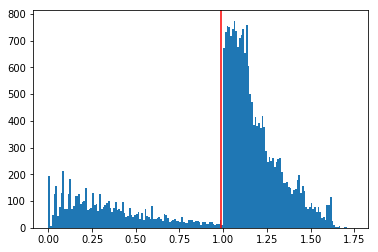

In [15]:
# Plot distribution of InvestorReturnRatios
bins = np.arange(0, 1.75, 0.01)
plt.hist(x=loans_closed[loans_closed.PostRelaunch == True].InvestorReturnRatio, bins=bins);
plt.axvline(loans_closed[loans_closed.PostRelaunch == True].InvestorReturnRatio.mean(), color='r');

The distribution of InvestorReturnRatios clearly reflects the distinct influences of successful loans (LoanStatus = Completed) and unsuccessful loans (LoanStatus = Chargedoff or Defaulted) where successful loans have an InvestorReturnRatio > 1.0 and unsuccessful loans primarily have InvestorReturnRatio < 1.0. Since this plot only includes post-relaunch loans that have closed, the overall average InvestorReturnRatio is actually slightly less than one due to the failure rate of early post-relaunch loans was still relatively high.

The following plots show the distributions InvestorReturnRatios for successful and unsuccessful loans separately.

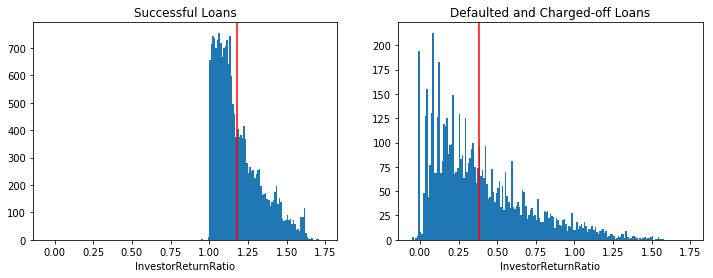

In [16]:
# plot distribution of InvestorReturnRatio values for the different LoanStatus
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))
bins = np.arange(-0.05, 1.75, 0.01)
ax[0,0].hist(x=loans_closed[loans_closed.PostRelaunch == True][loans_closed.LoanStatus == 'Completed'].InvestorReturnRatio, bins=bins)
ax[0,0].set_title('Successful Loans')
ax[0,0].set_xlabel('InvestorReturnRatio')
ax[0,0].axvline(loans_closed[loans_closed.PostRelaunch == True][loans_closed.LoanStatus == 'Completed'].InvestorReturnRatio.mean(), color='r')

ax[0,1].hist(x=loans_closed[loans_closed.PostRelaunch == True][loans_closed.LoanStatus != 'Completed'].InvestorReturnRatio, bins=bins);
ax[0,1].set_title('Defaulted and Charged-off Loans')
ax[0,1].set_xlabel('InvestorReturnRatio')
ax[0,1].axvline(loans_closed[loans_closed.PostRelaunch == True][loans_closed.LoanStatus != 'Completed'].InvestorReturnRatio.mean(), color='r')

## Creditworthiness Variables' Relationships to Loan Performance

How do the creditworthiness metrics relate to loan performance? The following plots show the statistics of the InvestorReturnRatio across the range of each of the creditworthiness variables. While clearly the statistical spread of loan performance is significantly higher for borrowers with lower creditworthiness it's important to note that the _median_ investor return is often higher for these riskier borrowers due to the higher interest rate that they pay. However, also note that the _mean_ investor return ratio (plotted as a green triangle) is significantly lower than the median in most of these lower credit quality categories.

Text(0.5, 1.0, 'InvestorReturnRatio Mean vs. ProsperRating')

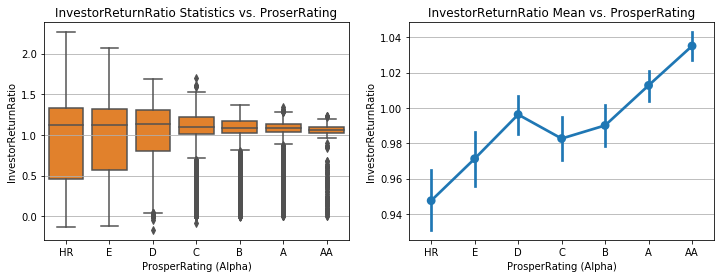

In [34]:
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))
plt.sca(ax[0,0])

# box plot InvestorReturnRatio against ProsperRating
base_color=sb.color_palette()[1]
cat_order=['HR','E','D','C','B','A','AA']
sb.boxplot(data=loans_closed, x='ProsperRating (Alpha)', y='InvestorReturnRatio', color=base_color, order=cat_order)
plt.title('InvestorReturnRatio Statistics vs. ProserRating')
plt.grid(b=True, which='major', axis='y')

plt.sca(ax[0,1])
# Pointplot InvestorReturnRatio against ProsperRating showing means
cat_order=['HR','E','D','C','B','A','AA']
sb.pointplot(data=loans_closed, y='InvestorReturnRatio', x='ProsperRating (Alpha)', showmeans=True, order=cat_order)
plt.grid(b=True, which='major', axis='y')
plt.title('InvestorReturnRatio Mean vs. ProsperRating')

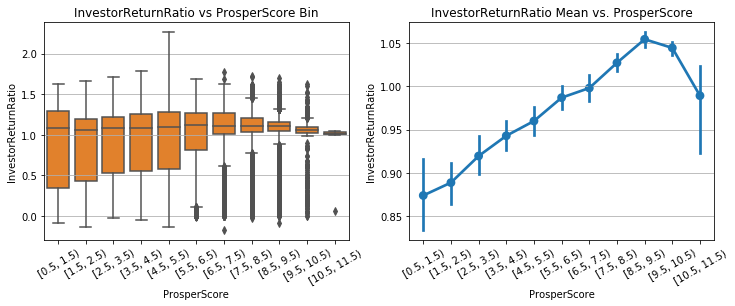

In [31]:
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))
plt.sca(ax[0,0])

# box plot InvestorReturnRatio against ProsperScore bins
# set bin edges, compute centers
xbin_size = 1
xbin_edges = np.arange(0.5, loans_closed.ProsperScore.max()+xbin_size, xbin_size)

# compute statistics in each bin
prosper_score_bins = pd.cut(loans_closed['ProsperScore'], xbin_edges, right = False, include_lowest = True).to_frame()
prosper_score_bins['InvestorReturnRatio']=loans_closed['InvestorReturnRatio']
sb.boxplot(data=prosper_score_bins, x='ProsperScore', y='InvestorReturnRatio', color=base_color)
plt.grid(b=True, which='major', axis='y')
plt.title('InvestorReturnRatio vs ProsperScore Bin')
plt.xticks(rotation='30');

plt.sca(ax[0,1])
# Pointplot InvestorReturnRatio against ProsperScore showing means
sb.pointplot(data=prosper_score_bins, x='ProsperScore', y='InvestorReturnRatio', showmeans=True)
plt.grid(b=True, which='major', axis='y')
plt.title('InvestorReturnRatio Mean vs. ProsperScore')
plt.xticks(rotation='30');

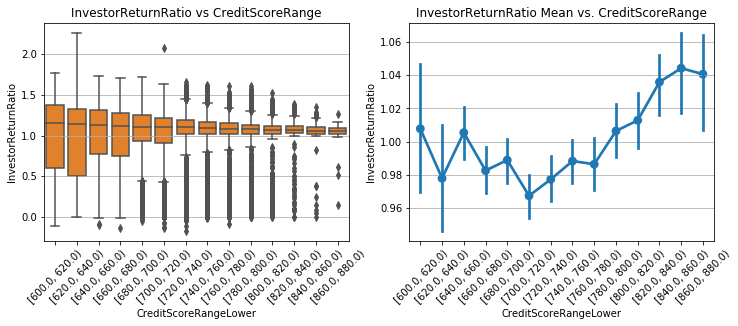

In [33]:
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))
plt.sca(ax[0,0])

# box plot InvestorReturnRatio against CreditScoreRanges
post_loans_closed = loans_closed[loans_clean.PostRelaunch == True].dropna(subset=['ClosedDate'])

# set bin edges, compute centers
xbin_size = 20
xbin_edges = np.arange(600, post_loans_closed.CreditScoreRangeLower.max()+xbin_size, xbin_size)

# compute statistics in each bin
credit_score_bins = pd.cut(loans_closed['CreditScoreRangeLower'], xbin_edges, right = False, include_lowest = True).to_frame()
credit_score_bins['InvestorReturnRatio']=post_loans_closed['InvestorReturnRatio']
sb.boxplot(data=credit_score_bins, x='CreditScoreRangeLower', y='InvestorReturnRatio', color=base_color)
plt.grid(b=True, which='major', axis='y')
plt.title('InvestorReturnRatio vs CreditScoreRange')
plt.xticks(rotation='45');

plt.sca(ax[0,1])
# Pointplot InvestorReturnRatio against ProsperScore showing means
sb.pointplot(data=credit_score_bins, x='CreditScoreRangeLower', y='InvestorReturnRatio', showmeans=True)
plt.grid(b=True, which='major', axis='y')
plt.title('InvestorReturnRatio Mean vs. CreditScoreRange')
plt.xticks(rotation='45');

## Fraud

One observation of interest in the distribution plots of InvestorReturnRatio was the spike at zero. In order for the InvestorReturnRatio to be so close to exactly zero the borrower never made a payment on the loan at all. The borrower accepted the funds and never paid anything back. Such loans could be considered fraudulent or at least potentially so. Recalling that the ProsperScore was specifically designed to predict loans that "go bad" within the first year and clearly these zero payment loans fall into that category, it would be interesting to see how well this metric did in these zero-payment loan cases. The following heatmap plots the number of these potentially fraudulent loans fall into ProsperScore bins in one dimension and ProsperRating category in the other dimension. This admittedly limited number of potentially fraudulent loans indicate that ProsperRating is a better predictor of such loans than ProsperScore.

Text(0.5, 1.0, 'Fraudulent(?) Loan Count vs ProsperRating & ProsperScore')

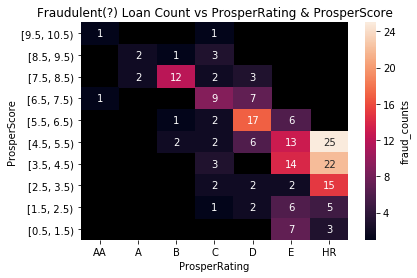

In [19]:
# Plot count of defaulted laans that had an InvesterReturnRatio of close to zero against ProsperScore and ProsperRating.
# These loans could represent fraud.
prosper_score_bins['ProsperRating']=loans_closed['ProsperRating (Alpha)']
fraud = prosper_score_bins[prosper_score_bins.InvestorReturnRatio.between(-0.01,0.01)]
fraud_counts = fraud.groupby(['ProsperRating', 'ProsperScore']).size()
fraud_counts = fraud_counts.reset_index(name="fraud_counts")
fraud_counts = fraud_counts.pivot(index='ProsperScore', columns='ProsperRating', values='fraud_counts')

# rearrange order of columns
cat_order=['AA','A','B','C','D','E','HR']
fraud_counts = fraud_counts[cat_order]

# rearrange order of rows
fraud_counts.sort_index(ascending=False, inplace=True)

g = sb.heatmap(fraud_counts, annot=True, fmt='.0f', cbar_kws={'label':'fraud_counts'})
g.set_facecolor('black')
plt.title('Fraudulent(?) Loan Count vs ProsperRating & ProsperScore')